# National Climate Dynamics Workshop - Python Short Course

The remainder of this short course will introduce `pygeode`, a Python package designed for accessing, processing, and visualizing gridded geophysical data. It is an alternative to `xarray` or to `IRIS`. PyGeode uses `numpy` and `matplotlib` extensively for underlying computations and plotting, and is designed around three main principles: 

1. Data should be represented and manipulated in geophysical coordinates
2. Data should be 'lazy-loaded', i.e. left on disk until needed for computation
3. Plotting defaults should be as close to publication quality as possible

Full documentation about pygeode including a tutorial, gallery, and API reference, can be found at [pygeode.github.io](https://pygeode.github.io).

This introduction is split into three Jupyter notebooks. Each 'workbook' consists of a set of pre-written examples to introduce some of pygeode functionality, followed by a simple example to give you the chance to work with pygeode yourself.

## PyGeode Workbook #2: Visualizing a single NetCDF file

The basic objects of pygeode (datasets, variables, and axes) map closely to the structure of netcdf files; PyGeode handles these naturally. In this second notebook we'll look at opening a single netcdf file and producing further customized plots.

In [1]:
# C0.0 Setup matplotlib backend for inline interactive plots
%matplotlib ipympl

In [2]:
# C0.0 Import pygeode, numpy, and matplotlib plotting packages
import pygeode as pyg
import numpy as np
from matplotlib import pyplot as plt

### 1. Opening a single NetCDF File

Opening a NetCDF file is a simple operation:

In [74]:
pyg.save('era5_202001_pl_uvt.nc', ds1)

In [72]:
ds1 = ds(l_lat=np.arange(-90,90,2.5), l_lon=np.arange(0,360,5), i_time=(0,2))
print(ds1)

<Dataset>:
Vars:
  t (time,level,latitude,longitude)  (2,37,72,72)
  u (time,level,latitude,longitude)  (2,37,72,72)
  v (time,level,latitude,longitude)  (2,37,72,72)
Axes:
  time <StandardTime>:  Jan 1, 2020 00:00:00 to Jan 1, 2020 06:00:00 (2 values)
  level <NamedAxis 'level'>:  1  to 1000  (37 values)
  latitude <Lat> :  88 N to 90 S (72 values)
  longitude <Lon>:  0 E to 355 E (72 values)
Global Attributes:
  Conventions    : CF-1.6
  history        : 2020-06-23 20:44:35 GMT by grib_to_netcdf-2.16.0: [...]


In [71]:
# C1.1 Open NetCDF file

# Set this path to wherever you've stored the sample data provided.
data_pth = './'

ds = pyg.open(data_pth + 'era5_202001_pl_uvt_o.nc')

print(ds)

<Dataset>:
Vars:
  t (time,level,latitude,longitude)  (124,37,181,360)
  u (time,level,latitude,longitude)  (124,37,181,360)
  v (time,level,latitude,longitude)  (124,37,181,360)
Axes:
  time <StandardTime>:  Jan 1, 2020 00:00:00 to Jan 31, 2020 18:00:00 (124 values)
  level <NamedAxis 'level'>:  1  to 1000  (37 values)
  latitude <Lat> :  90 N to 90 S (181 values)
  longitude <Lon>:  0 E to 359 E (360 values)
Global Attributes:
  Conventions    : CF-1.6
  history        : 2020-06-23 20:44:35 GMT by grib_to_netcdf-2.16.0: [...]


This file includes three variables, representing one month of 6-hourly horizontal winds and temperatures from the ERA 5 reanalysis.

The underlying data can be accessed directly and treated like a `numpy` array, if it is small enough to fit in memory. However, by default, PyGeode does not load this data into memory until it is actually needed, for plotting or to write to disk, for instance. This particular NetCDF file is several gigabytes on disk; the above command has read only the metadata required to setup the variables and axes and so executes fairly quickly. 

PyGeode recognizes CF metadata conventions, and so we see above that it has identified the time, latitude, and longitude axes and created instances of appropriate `Axis` subclasses. 

However, despite these conventions there are still many variants present in the wild, and not all NetCDF files will be well-formed. In this case PyGeode has not recognized the vertical `level` axis, and so it has used a catch-all subclass called a `NamedAxis`. 

Let's go ahead and make an initial plot.

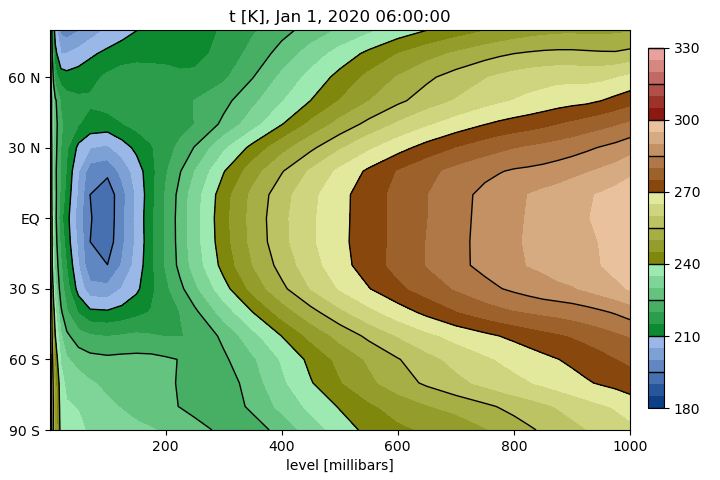

In [45]:
# C1.2 Plot the zonal mean temperature for one timestep

# The following compute the zonal mean; NB this still does not load data!
t_zm = ds.t.mean('lon')

# Plotting a single time step involves accessing data, but only the data that is needed will be accessed from disk
pyg.showvar(t_zm(time = '06:00 1 Jan 2020'))

This produces a somewhat recognizeable plot of the zonal mean temperature field, but because `level` is not recognized as a pressure level coordinate, the plotting routine doesn't know to use it as the y-axis of the plot.

We can correct this in several ways:

In [46]:
# C1.3 Replace level axis

# One approach is to create an appropriate axis manually:
pres = pyg.Pres(ds.level[:])

# The following replaced the 'level' axis with our new 'pres' axis on all variables in the dataset
dsp = ds.replace_axes(level = pres)
print(dsp)

<Dataset>:
Vars:
  t (time,pres,latitude,longitude)  (2,37,18,24)
  u (time,pres,latitude,longitude)  (2,37,18,24)
  v (time,pres,latitude,longitude)  (2,37,18,24)
Axes:
  time <StandardTime>:  Jan 1, 2020 00:00:00 to Jan 1, 2020 06:00:00 (2 values)
  pres <Pres>    :  1 hPa to 1000 hPa (37 values)
  latitude <Lat> :  80 N to 90 S (18 values)
  longitude <Lon>:  0 E to 345 E (24 values)
Global Attributes:
  Conventions    : CF-1.0
  history        : 2020-06-23 20:44:35 GMT by grib_to_netcdf-2.16.0: [...]


In [75]:
# C1.4 Use arguments to pyg.open() to tailor the dataset

# In this case we'll tell pyg.open() to use a <Pres> instance for the level axis using the 'dimtypes' argument
# We'll also use the 'namemap' keyword argument to simplify the names of the lat and lon axes

ds = pyg.open(data_pth + 'era5_202001_pl_uvt.nc', \
              dimtypes = dict(level = pyg.Pres), \
              namemap = dict(latitude = 'lat', longitude = 'lon'))

print(ds)

<Dataset>:
Vars:
  t (time,level,lat,lon)  (2,37,72,72)
  u (time,level,lat,lon)  (2,37,72,72)
  v (time,level,lat,lon)  (2,37,72,72)
Axes:
  time <StandardTime>:  Jan 1, 2020 00:00:00 to Jan 1, 2020 06:00:00 (2 values)
  level <Pres>   :  1  to 1000  (37 values)
  lat <Lat>      :  88 N to 90 S (72 values)
  lon <Lon>      :  0 E to 355 E (72 values)
Global Attributes:
  Conventions    : CF-1.0
  history        : 2020-06-23 20:44:35 GMT by grib_to_netcdf-2.16.0: [...]


In either case, now our plot will be better formed:

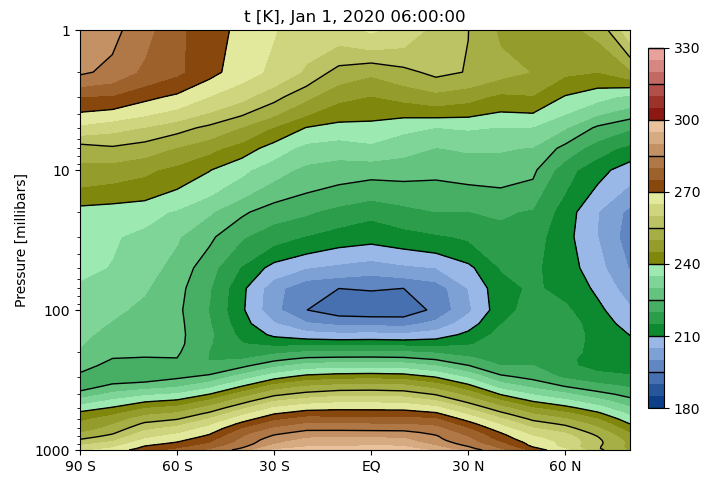

In [48]:
# C1.5 Replot the zonal mean temperature for one timestep

# The following compute the zonal mean; NB this still does not load data!
t_zm = ds.t.mean('lon')

# Plotting a single time step involves accessing data, but only the data that is needed will be accessed from disk
pyg.showvar(t_zm(time = '06:00 1 Jan 2020'))

### 2. Further customizing plots

So far we've used 'high-level' plotting functions provided by PyGeode: `showvar` and `showlines`. For a bit more control over the plots, there are a lower-level set of plotting routines.

In this section we'll produce a plot of the monthly mean temperature, with the montly mean zonal wind over plotted using contour lines.

We'll start by computing the time and zonal mean of the whole dataset, and to save time later on, we'll go ahead and load this data into memory.

In [62]:
#C2.1 Compute time, zonal mean of all variables in dataset, load this into memory
dsz = ds.mean('time', 'lon').load()

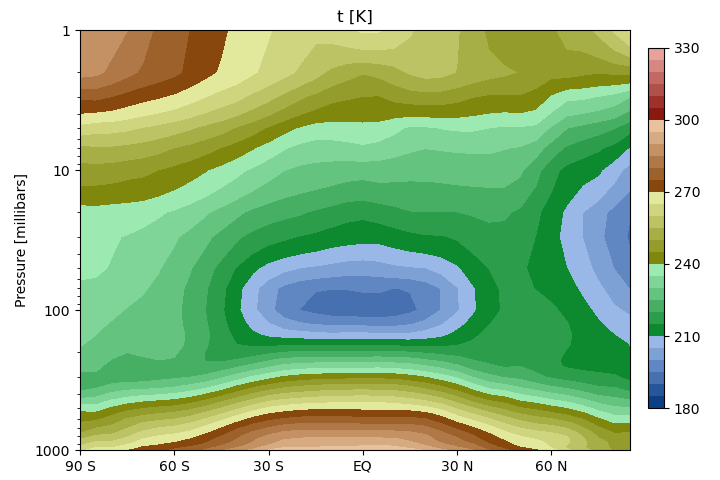

In [63]:
#C2.2 Create plot of temperatures using showvar
ax = pyg.showvar(dsz.t, nl = 0)

In [64]:
print(ax.axes)

[<pygeode.plot.wrappers.AxesWrapper object at 0x7f3b42433b10>, <pygeode.plot.wrappers.AxesWrapper object at 0x7f3b425dead0>]


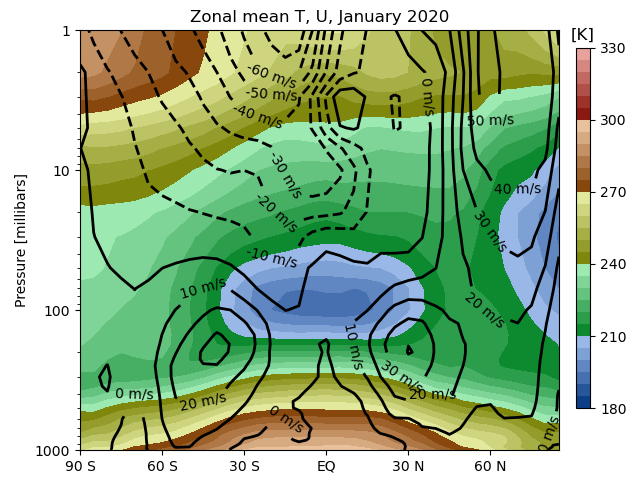

In [65]:
#C2.3 Add zonal wind plot

cu = pyg.cldict(10., colors = 'k', linewidths = 2.)

fig = plt.figure()

plt.ioff()

ax = pyg.showvar(dsz.t, nl = 0)

pyg.vcontour(dsz.u, axes = ax.axes[0], **cu)
ax.axes[0].clabel(ax.axes[0].plots[-1], fmt = '%d m/s')

ax.axes[0].setp(title = 'Zonal mean T, U, January 2020')
ax.axes[1].setp(title = '[K]')
ax.render(fig=fig)
plt.ion()

plt.show()

### 3. Map Projections

Finally, we'll briefly describe how to use different projections.

The simplest approach is as follows:

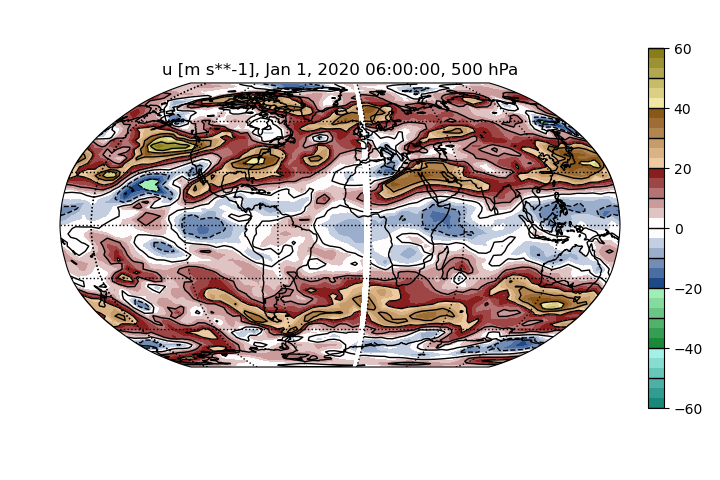

In [76]:
#C3.1 Plot zonal wind in a Robinson projection
prj_args = dict(central_longitude = -20)
pyg.showvar(ds.u(time = '06:00 1 Jan 2020', pres = 500), \
            map = dict(projection = 'Robinson', prj_args = prj_args))

This works well if the default parameters for the projection are what you're looking for, or if you don't need to do too much customization. 

Another approach involves creating the map container first:

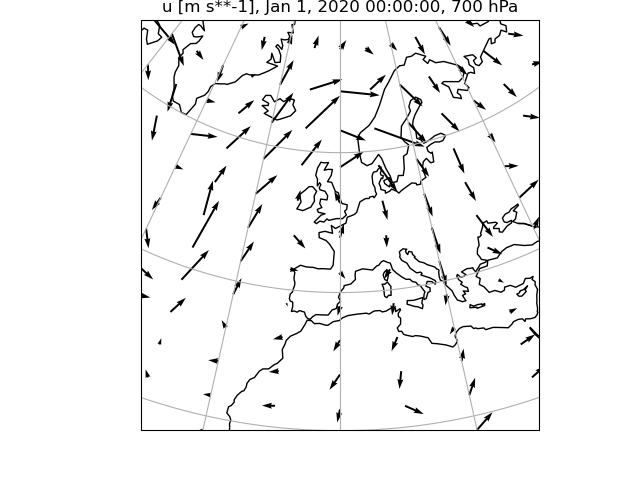

In [92]:
#C3.2 Plot wind quivers on regional LambertConformal projection
import cartopy.crs as ccrs

fig = plt.figure()
plt.ioff()

# Create axes wrapper with projection details
ax = pyg.plot.CartopyAxes(projection = 'LambertConformal', \
                          prj_args = dict(central_longitude=0., central_latitude = 39.))

def sel(var): return var(time = '00:00 1 Jan 2020', pres = 700, i_lon = (0, -1, 2), i_lat = (0, -1, 2))

# Plot wind quivers
pyg.vquiver(sel(ds.u), sel(ds.v), axes=ax, width = 0.005, scale = 300, mapdecor = dict(gridlines=False))


# Set lat/lon grid
ax.gridlines(xlocs = range(-60, 60, 20), ylocs = range(0, 81, 20))

# Set spatial extent to region over North America (lon0, lon1, lat0, lat1)
ax.set_extent([-30, 30, 20, 75], crs = ccrs.PlateCarree())
ax.render(fig=fig)
plt.ion()

plt.show()

## Exercise:

Make a NP stereographic plot showing the time-mean winds at 10 hPa using quivers over the Arctic. Overplot contours of wind speed.